<a id=contents></a>

# Extraction and cleaning notebook
## Data retrieved from glassdoor.com

Data was extracted via Glassdoor's REST API (documentation here: https://www.glassdoor.com/developer/index.htm). 

[1. Data Inspection](#insp)

[2. Cleaning text data](#text)

In [98]:
import pandas as pd
import os
import time
import requests as req
from dotenv import load_dotenv
load_dotenv()
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set_style("darkgrid")

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
import string

from nltk.corpus import stopwords
from nltk import FreqDist
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
import re
tokenizer = RegexpTokenizer(r'\b\w{3,}\b')
stop_words = list(set(stopwords.words("english")))
stop_words += list(string.punctuation)

import warnings
warnings.filterwarnings('ignore')

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<a id=insp ><a/> 

## 1. Data Inspection
    
[LINK to table of contents](#contents)

Now that we have a list of strings, we can check the length, the size of string and what the most frequent terms will be, which'll give us an insight into what we need to clean.

In [24]:
ds_jobs = pd.read_pickle('ds_jobs_raw.pkl')
ds_jobs.head()

,job_url,job_descr
0,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,We would like to reassure all applicants that ...
1,https://www.indeed.co.uk/rc/clk?jk=e96b45c3c7a...,Job Title: Artificial Intelligence – Data Scie...
2,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,"A career within Forensics Technology services,..."
3,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,"White Collar Factory (95009), United Kingdom, ..."
4,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,We are a digitally native technology services ...


In [25]:
ds_jobs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 510 entries, 0 to 509
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   job_url    510 non-null    object
 1   job_descr  510 non-null    object
dtypes: object(2)
memory usage: 8.1+ KB


In [26]:
ds_jobs.job_descr.nunique()

247

In [27]:
ds_jobs.job_url.nunique()

253

It's very odd that we'd see different numbers of duplicates between the two columnns. Given that it's the text we're most interested in, we're gonna drop duplicates via the job description column first.

In [28]:
ds_jobs.drop_duplicates(inplace=True, subset='job_descr')

In [29]:
ds_jobs.shape

(247, 2)

In [30]:
ds_jobs.head()

,job_url,job_descr
0,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,We would like to reassure all applicants that ...
1,https://www.indeed.co.uk/rc/clk?jk=e96b45c3c7a...,Job Title: Artificial Intelligence – Data Scie...
2,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,"A career within Forensics Technology services,..."
3,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,"White Collar Factory (95009), United Kingdom, ..."
4,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,We are a digitally native technology services ...


Important to give the frequency of terms a quick gland and see what is dominating our vocabulary. At this basic EDA stage we can pick up a lot of the unclean data.

In [56]:
final_str = []
job_descr_list = [text for text in ds_jobs.job_descr.values]
for job in job_descr_list:
    tokenized_job = tokenizer.tokenize(job)
    for token in tokenized_job:
        final_str.append(token)
        
f_dist = FreqDist([word.lower() for word in final_str])
f_dist

FreqDist({'and': 5750, 'the': 3771, 'data': 2189, 'with': 1557, 'you': 1326, 'for': 1302, 'our': 1149, 'experience': 860, 'will': 801, 'are': 777, ...})

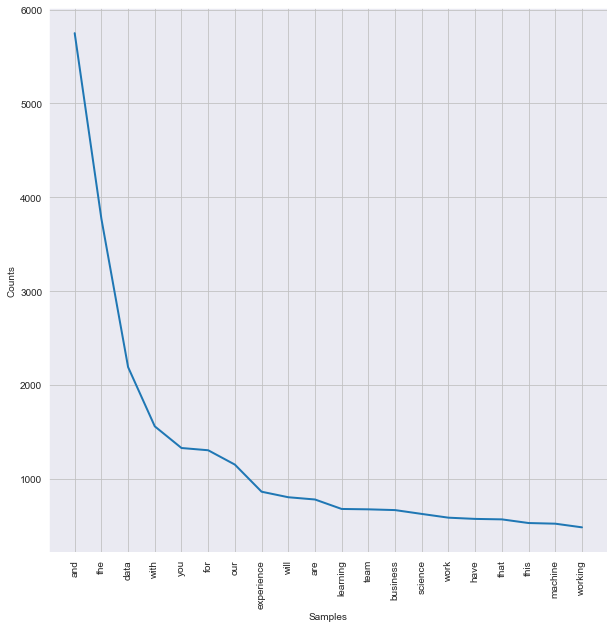

In [78]:
plt.figure(figsize=(10,10))
f_dist.plot(20);

Now let's see what our data would look like without stop words.

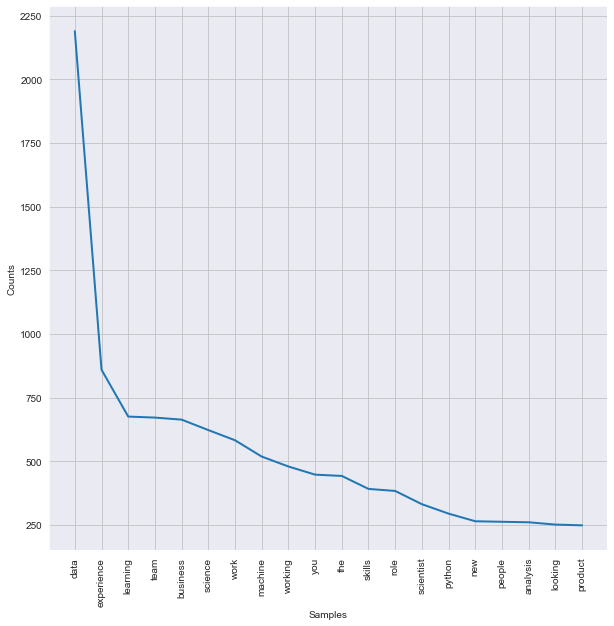

In [80]:
final_str = []
job_descr_list = [text for text in ds_jobs.job_descr.values]
for job in job_descr_list:
    tokenized_job = tokenizer.tokenize(job)
    for token in tokenized_job:
        if token not in stop_words:
            final_str.append(token)
        
f_dist = FreqDist([word.lower() for word in final_str])

plt.figure(figsize=(10,10))
f_dist.plot(20);

Ok, so with this distribution in mind it seems that we're getting much, much cleaner data and our tokenizer seems to have parsed through a lot of potential rubbish. A good question would be whether we want to include 'data' or not. For the purpose of comparing later to the ML Eng data, let's keep it in. We will now explore the ML Eng data similarly. 

In [81]:
mleng_jobs = pd.read_pickle('mleng_jobs_raw.pkl')
print(mleng_jobs.nunique())
mleng_jobs.head()

job_url      240
job_descr    233
dtype: int64


,job_url,job_descr
0,https://www.indeed.co.uk/rc/clk?jk=de31d78a914...,About us\n\nWe created Peanut with the idea th...
1,https://www.indeed.co.uk/rc/clk?jk=4c460bbd6a3...,OakNorth is the next-generation credit and mon...
2,https://www.indeed.co.uk/rc/clk?jk=110484a7c65...,Echobox has access to very large granular priv...
3,https://www.indeed.co.uk/rc/clk?jk=adc2d336aec...,The Personalization team makes deciding what t...
4,https://www.indeed.co.uk/rc/clk?jk=0454454cafb...,Responsibilities\nTikTok is the leading destin...


In [82]:
mleng_jobs.drop_duplicates('job_descr', inplace=True)

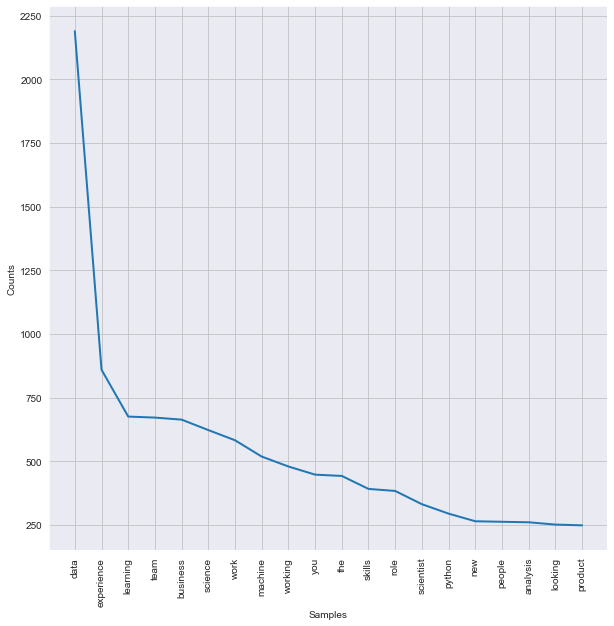

In [87]:
final_str = []
job_descr_list = [text for text in ds_jobs.job_descr.values]
for job in job_descr_list:
    tokenized_job = tokenizer.tokenize(job)
    for token in tokenized_job:
        if token not in stop_words:
            final_str.append(token)
        
f_dist = FreqDist([word.lower() for word in final_str])
plt.figure(figsize=(10,10))
f_dist.plot(20);

We'll merge the data sets now, but adding a categorical column for ML engineering job posts. A value of 1 means the job came up in the ML Engineering job search.

In [89]:
ds_jobs['is_mleng'] = 0
mleng_jobs['is_mleng'] = 1

df = pd.concat([ds_jobs, mleng_jobs], axis=0)
df.shape

(480, 3)

In [91]:
df.nunique()

job_url      440
job_descr    437
is_mleng       2
dtype: int64

As we would have expected we have some job posts that came up in both searches. Since the URL and is_mleng variables can track which came from where, we will leave them in for now and look at them later in more detail.

<a id=text ><a/> 

## 2. Cleaning text data
    
[LINK to table of contents](#contents)
    
We will preprocess the text data by removing any emails, websites and lemmatizing our text.

In [99]:
stop_words += list(string.punctuation)
lemmy = WordNetLemmatizer()


In [105]:
def preprocess_data(string):
    """As a precautionary measure we should try to remove any emails or websites that BS4 missed"""
    new_str = re.sub(r"\S+@\S+", '', string)
    new_str = re.sub(r"\S+.co\S+", '', new_str)
    new_str = re.sub(r"\S+.ed\S+", '', new_str)
    new_str_tok = tokenizer.tokenize(new_str)
    new_str_lemm = [lemmy.lemmatize(token) for token in new_str_tok]
    new_str_cont = ''
    for tok in new_str_lemm:
        new_str_cont += tok + ' '
    return new_str_cont

In [108]:
df.job_descr = df.job_descr.apply(preprocess_data)

In [109]:
df.head()

,job_url,job_descr,is_mleng
0,https://www.indeed.co.uk/pagead/clk?mo=r&ad=-6...,would like reassure all applicant that recruit...,0
1,https://www.indeed.co.uk/rc/clk?jk=e96b45c3c7a...,Job Title Artificial Intelligence Data Scienti...,0
2,https://www.indeed.co.uk/rc/clk?jk=7548e60a487...,career within Forensics Technology service wil...,0
3,https://www.indeed.co.uk/rc/clk?jk=cae641d93a8...,White Collar Factory 95009 United Kingdom Lond...,0
4,https://www.indeed.co.uk/rc/clk?jk=ef47bc3a6fc...,are digitally native technology where innovati...,0


Before unloading the data we will do one final visualization of the whole dataframe's text.

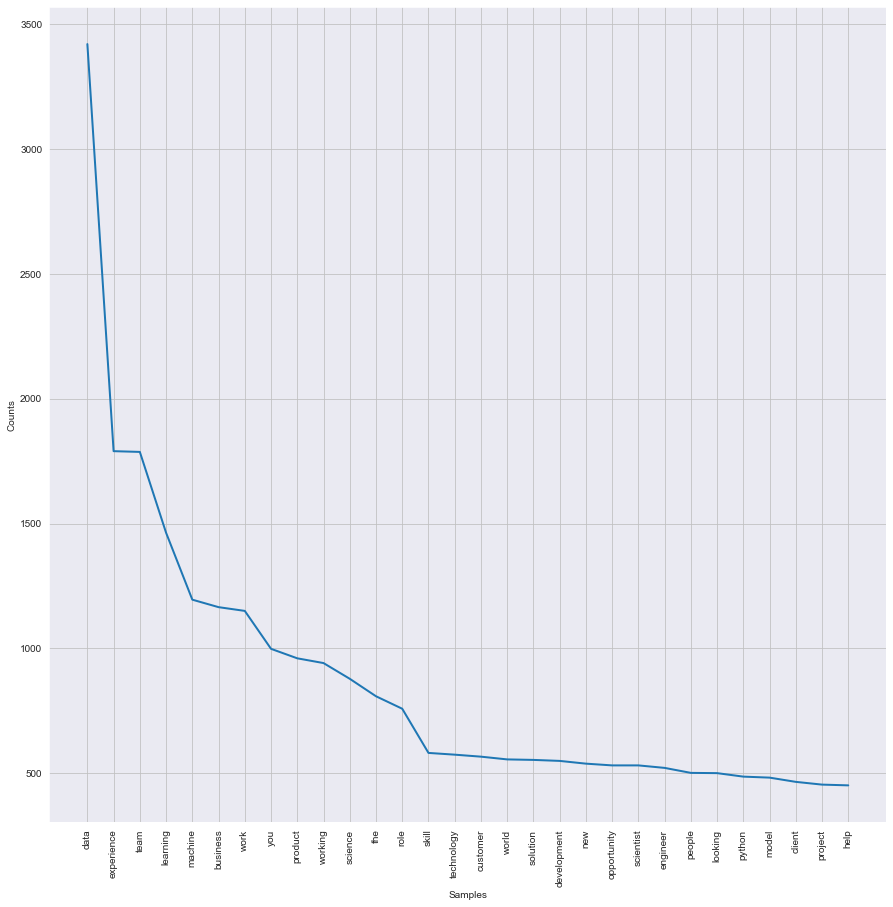

In [110]:
final_str = []
job_descr_list = [text for text in df.job_descr.values]
for job in job_descr_list:
    tokenized_job = tokenizer.tokenize(job)
    for token in tokenized_job:
        if token not in stop_words:
            final_str.append(token)
        
f_dist = FreqDist([word.lower() for word in final_str])
plt.figure(figsize=(15,15))
f_dist.plot(30);

In [112]:
# All seems good!

df.to_pickle('clean_data.pkl')